# Dive-in

Première analyse des données

Le contexte donné dans le PDF ne me permet pas de comprendre précisément où résident les potentiels problèmes de performance à analyser ni même la nature de ce qui tourne sur l'infra d'où on récupère les mesures.

L'approche sera donc la suivante :

1. Analyser les différentes métriques de performance pour comprendre le type de système étudié
2. Cibler les métriques qui peuvent révéler des problèmes de performance
3. Trouver des patterns dans les données
4. Développer des modules de diagnostic simulant notre propre analyse manuelle

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
with open('data/rapport.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Période couverte: {df.index.min()} à {df.index.max()}")
print(f"Nombre d'enregistrements: {len(df)}")

Dataset shape: (500, 14)
Période couverte: 2023-10-01 12:00:00+00:00 à 2023-10-11 21:30:00+00:00
Nombre d'enregistrements: 500


In [3]:
metrics_summary = df[['cpu_usage', 'memory_usage', 'latency_ms', 'disk_usage', 
                     'error_rate', 'temperature_celsius', 'power_consumption_watts']].describe()

print("=== Statistiques descriptives des métriques principales ===")
print(metrics_summary.round(2))

=== Statistiques descriptives des métriques principales ===
       cpu_usage  memory_usage  latency_ms  disk_usage  error_rate  \
count     500.00        500.00      500.00      500.00      500.00   
mean       60.67         67.63      156.02       63.91        0.03   
std        12.28          7.39       66.99        9.97        0.03   
min        52.00         62.00      113.00       57.00        0.02   
25%        54.00         63.00      124.00       59.00        0.02   
50%        56.00         66.00      132.00       60.00        0.02   
75%        59.00         67.00      139.00       62.00        0.02   
max        99.00         92.00      384.00       97.00        0.13   

       temperature_celsius  power_consumption_watts  
count               500.00                   500.00  
mean                 63.00                   263.98  
std                   7.73                    36.56  
min                  57.00                   238.00  
25%                  59.00             

In [4]:
print(df.dtypes)
print(df.head(3))

cpu_usage                    int64
memory_usage                 int64
latency_ms                   int64
disk_usage                   int64
network_in_kbps              int64
network_out_kbps             int64
io_wait                      int64
thread_count                 int64
active_connections           int64
error_rate                 float64
uptime_seconds               int64
temperature_celsius          int64
power_consumption_watts      int64
service_status              object
dtype: object
                           cpu_usage  memory_usage  latency_ms  disk_usage  \
timestamp                                                                    
2023-10-01 12:00:00+00:00         93            86         334          89   
2023-10-01 12:30:00+00:00         57            66         139          61   
2023-10-01 13:00:00+00:00         56            68         136          62   

                           network_in_kbps  network_out_kbps  io_wait  \
timestamp                       

In [5]:
service_statuses = pd.json_normalize(df['service_status'])
print(service_statuses.value_counts())

database  api_gateway  cache   
online    online       online      358
offline   online       online       59
online    degraded     online       49
                       degraded     18
          online       degraded     16
Name: count, dtype: int64


In [6]:
print(df.describe().T)

                         count          mean            std        min  \
cpu_usage                500.0      60.66800      12.276122      52.00   
memory_usage             500.0      67.62800       7.389101      62.00   
latency_ms               500.0     156.01800      66.994733     113.00   
disk_usage               500.0      63.90600       9.974776      57.00   
network_in_kbps          500.0    1361.50800     431.733132    1080.00   
network_out_kbps         500.0    1219.77400     316.454341     991.00   
io_wait                  500.0       4.01000       2.717475       2.00   
thread_count             500.0     151.50400       7.270744     143.00   
active_connections       500.0      58.86200      23.734228      48.00   
error_rate               500.0       0.03158       0.030291       0.02   
uptime_seconds           500.0  809100.00000  260067.298982  360000.00   
temperature_celsius      500.0      63.00200       7.725112      57.00   
power_consumption_watts  500.0     263

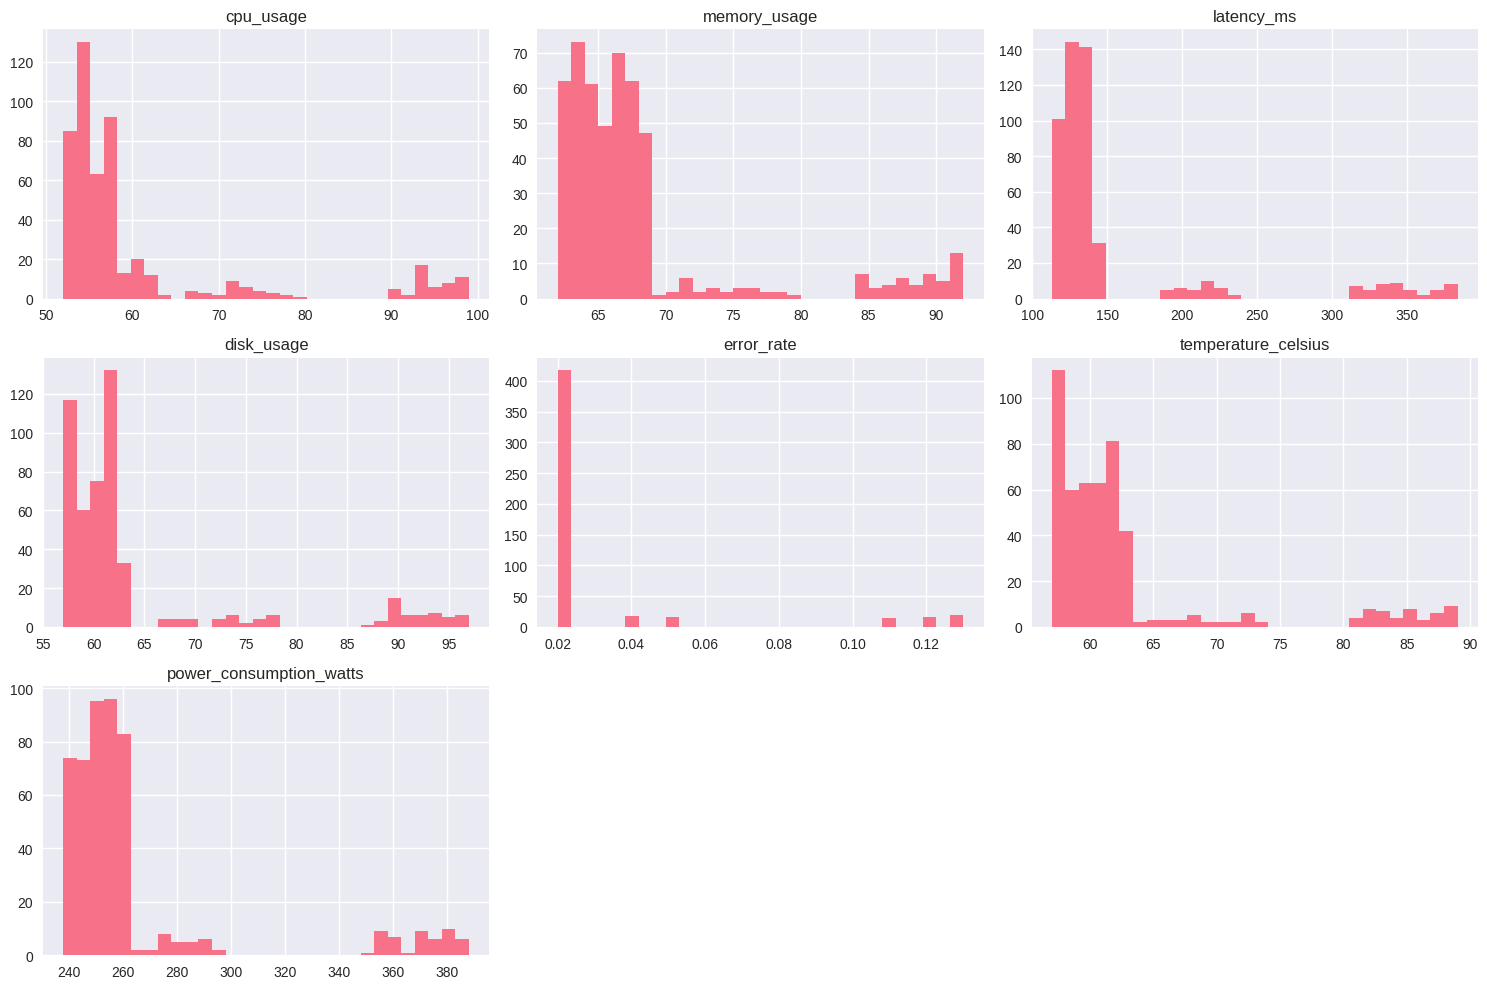

In [7]:
metrics = ['cpu_usage', 'memory_usage', 'latency_ms', 'disk_usage', 'error_rate', 'temperature_celsius', 'power_consumption_watts']
df[metrics].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

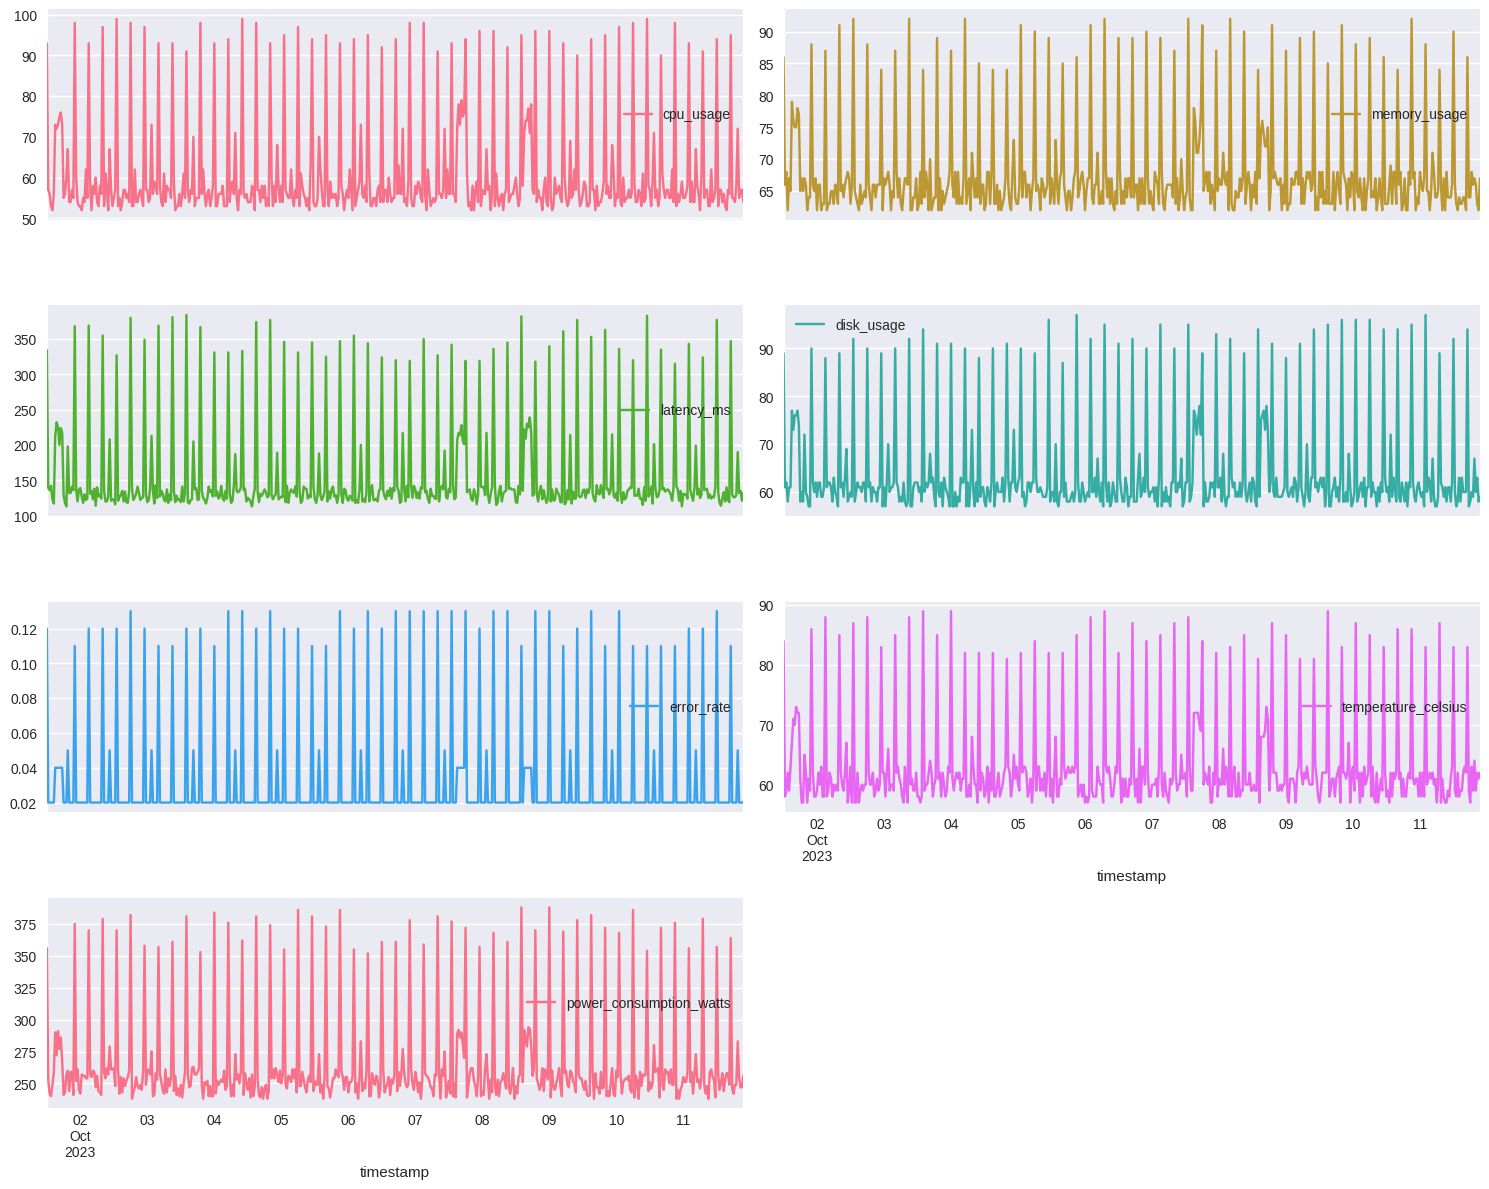

In [8]:
df[metrics].plot(subplots=True, figsize=(15, 12), layout=(4,2))
plt.tight_layout()
plt.show()

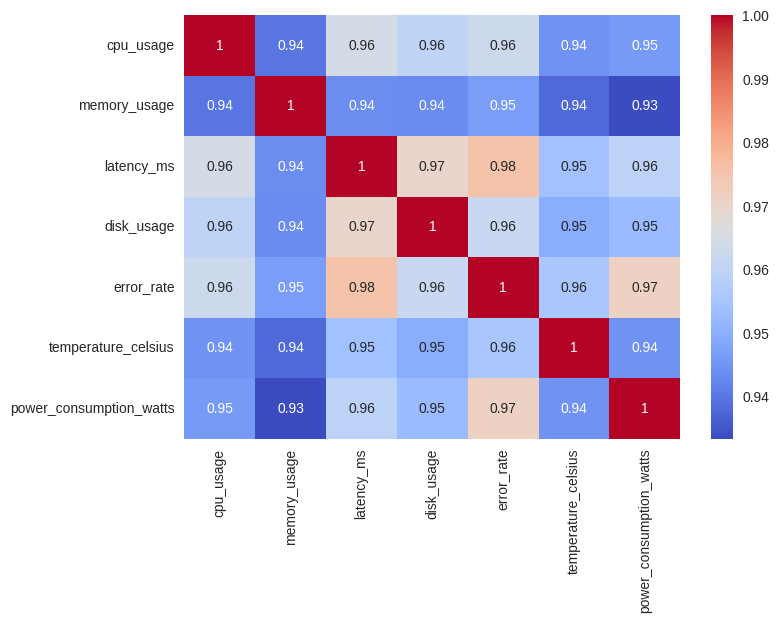

In [9]:
corr = df[metrics].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [10]:
# Fréquence des statuts dégradés ou offline
for service in ['database', 'api_gateway', 'cache']:
    print(f"{service} status counts:")
    print(service_statuses[service].value_counts())

database status counts:
database
online     441
offline     59
Name: count, dtype: int64
api_gateway status counts:
api_gateway
online      433
degraded     67
Name: count, dtype: int64
cache status counts:
cache
online      466
degraded     34
Name: count, dtype: int64


In [11]:
# Détection simple d'outliers pour chaque métrique
for col in metrics:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    outliers = df[(df[col] < q_low) | (df[col] > q_high)]
    print(f"{col}: {len(outliers)} outliers")

cpu_usage: 3 outliers
memory_usage: 0 outliers
latency_ms: 10 outliers
disk_usage: 2 outliers
error_rate: 0 outliers
temperature_celsius: 4 outliers
power_consumption_watts: 5 outliers


In [18]:
print(service_statuses.shape)
print(df.shape)

(500, 3)
(500, 14)


In [20]:
service_statuses.head()

,database,api_gateway,cache
0,online,degraded,online
1,online,online,online
2,online,online,online
3,online,online,online
4,online,online,online


In [21]:
# Create a copy of the dataframe
df_analysis = df.copy()

# Parse the service_status dictionary and create separate columns
df_analysis[['database', 'api_gateway', 'cache']] = df_analysis['service_status'].apply(lambda x: pd.Series([x['database'], x['api_gateway'], x['cache']]))

df_analysis.head()


,cpu_usage,memory_usage,latency_ms,disk_usage,network_in_kbps,network_out_kbps,io_wait,thread_count,active_connections,error_rate,uptime_seconds,temperature_celsius,power_consumption_watts,service_status,database,api_gateway,cache
timestamp,,,,,,,,,,,,,,,,,
2023-10-01 12:00:00+00:00,93,86,334,89,2541,2137,12,143,126,0.12,360000,84,356,"{'database': 'online', 'api_gateway': 'degrade...",online,degraded,online
2023-10-01 12:30:00+00:00,57,66,139,61,1171,1193,3,145,51,0.02,361800,58,253,"{'database': 'online', 'api_gateway': 'online'...",online,online,online
2023-10-01 13:00:00+00:00,56,68,136,62,1316,1147,3,147,49,0.02,363600,59,242,"{'database': 'online', 'api_gateway': 'online'...",online,online,online
2023-10-01 13:30:00+00:00,53,62,142,58,1090,1121,3,154,51,0.02,365400,62,240,"{'database': 'online', 'api_gateway': 'online'...",online,online,online
2023-10-01 14:00:00+00:00,52,67,123,61,1086,1123,3,145,48,0.02,367200,59,249,"{'database': 'online', 'api_gateway': 'online'...",online,online,online


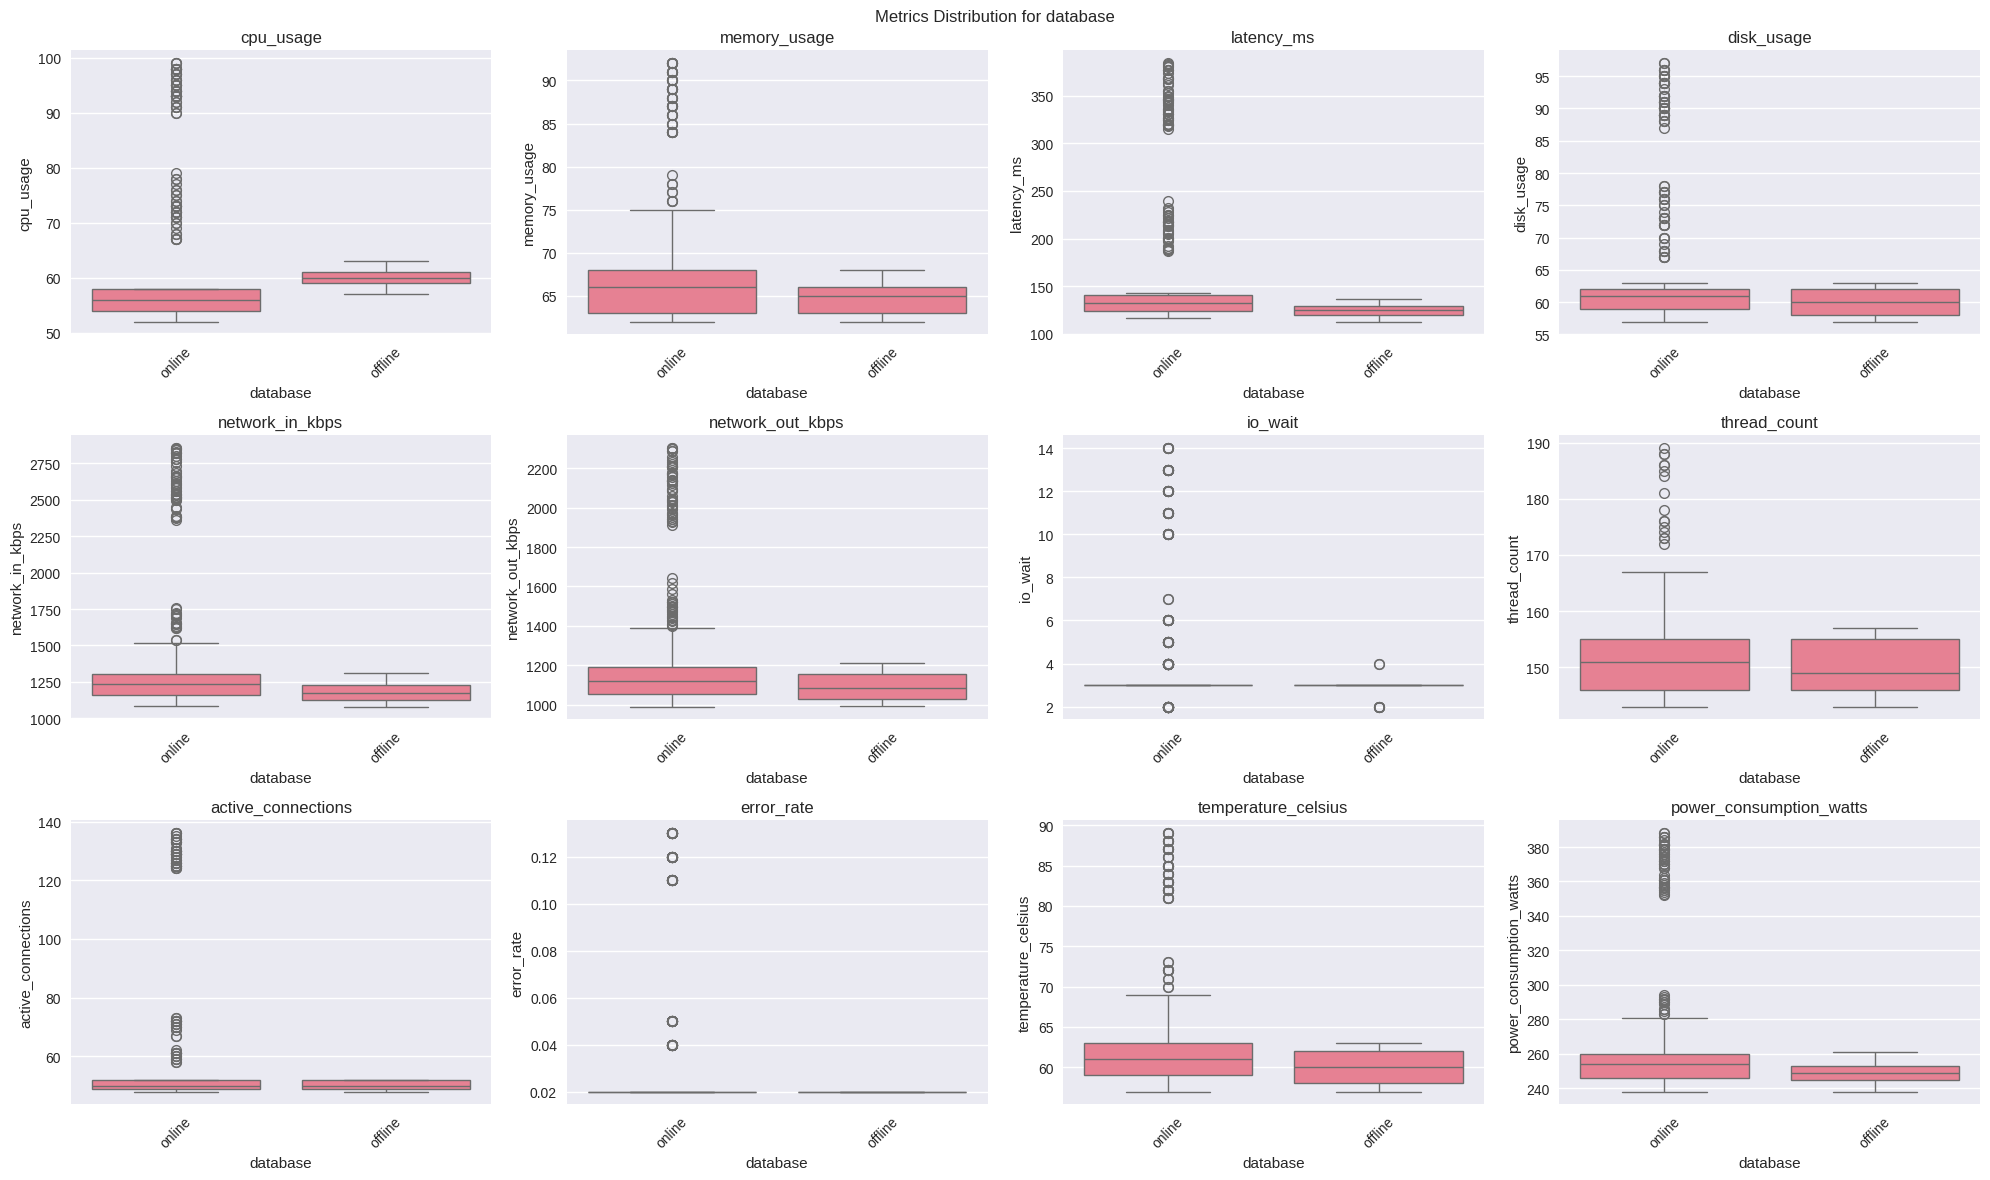

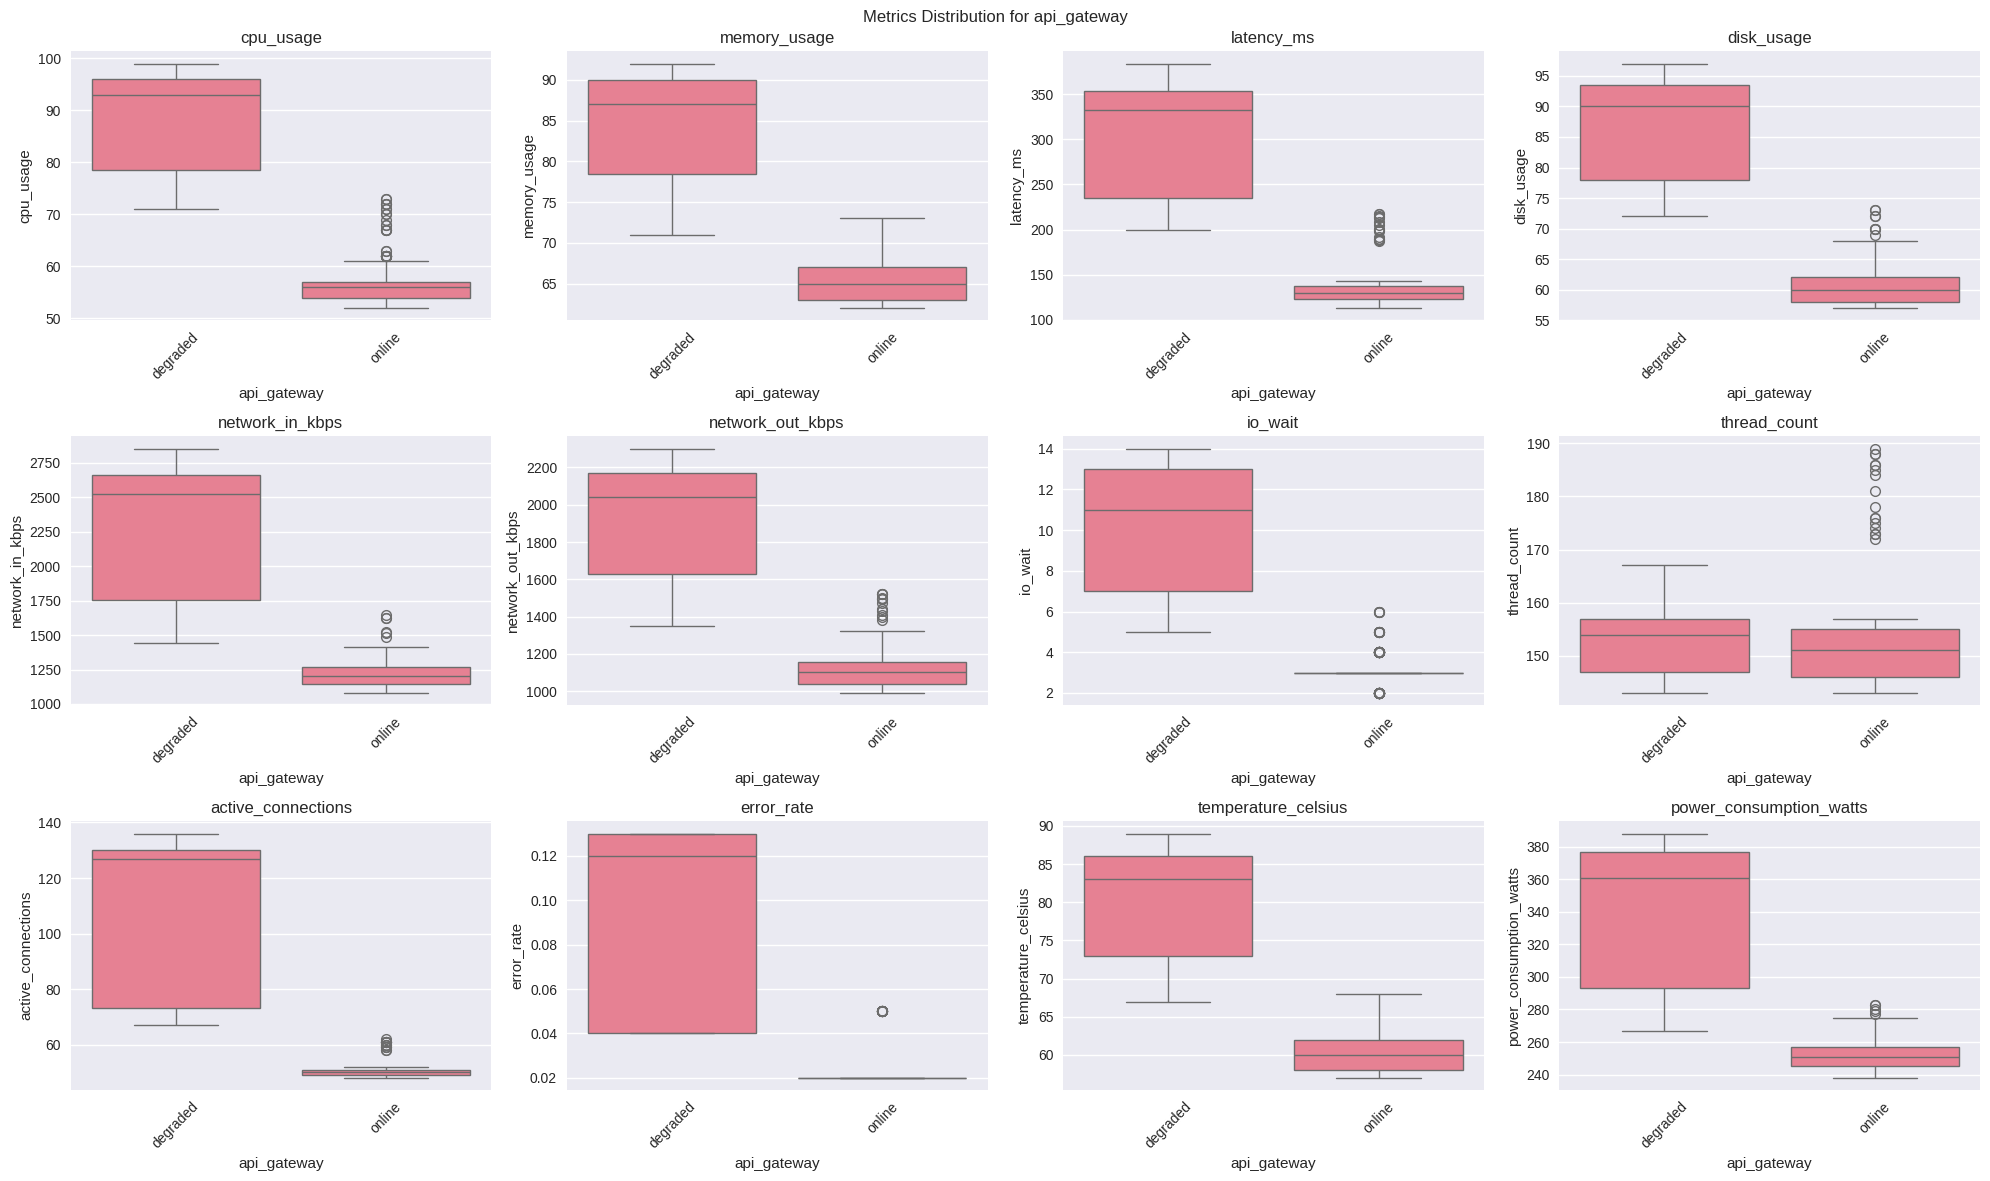

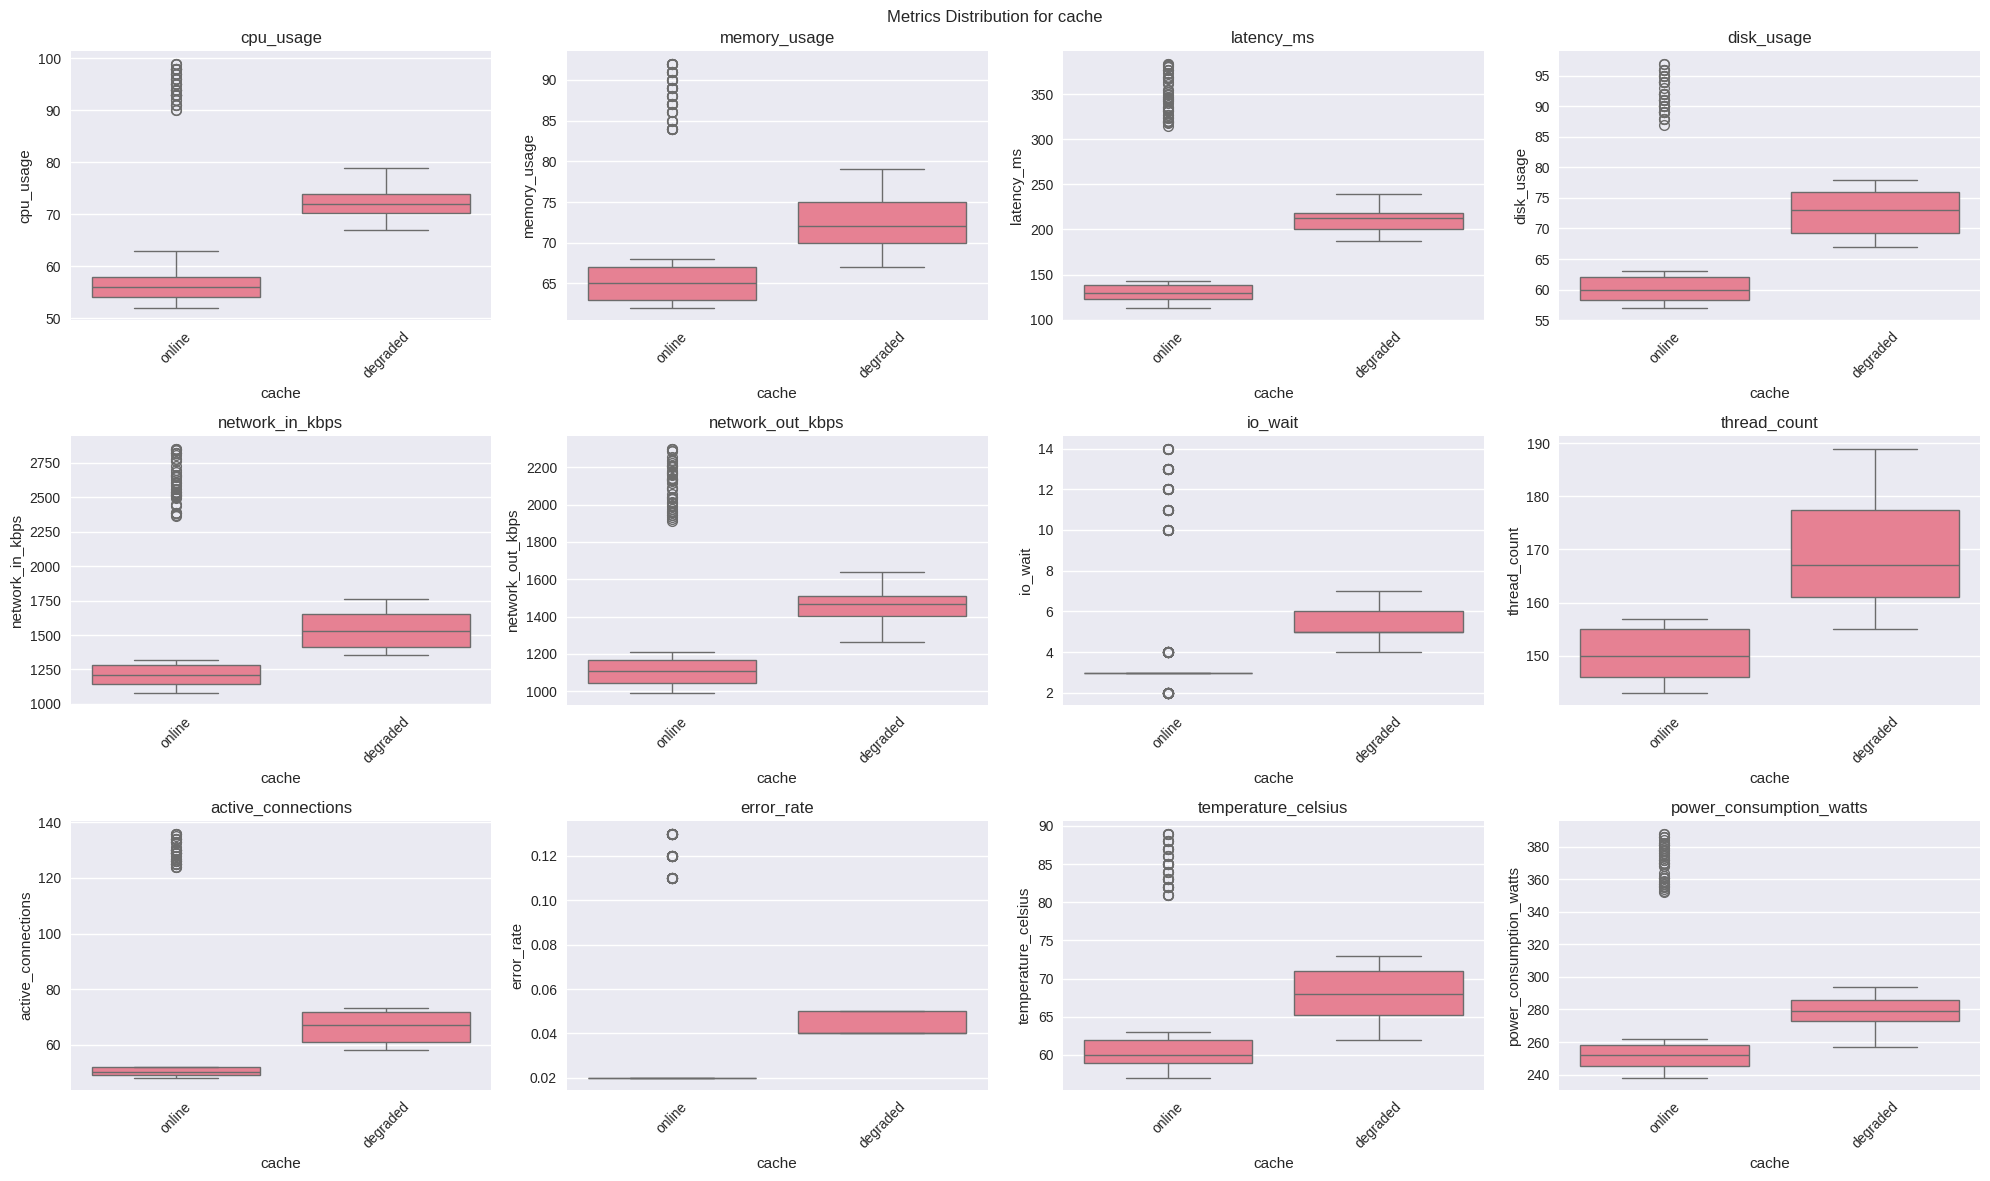

In [24]:
# Analyze metrics distribution based on service status
services = ['database', 'api_gateway', 'cache']
metrics = ['cpu_usage', 'memory_usage', 'latency_ms', 'disk_usage', "network_in_kbps",
            "network_out_kbps", "io_wait", "thread_count", "active_connections", "error_rate", 
            "temperature_celsius", "power_consumption_watts"]

for service in services:
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f'Metrics Distribution for {service}')
    axes = axes.flatten()
    
    for j, metric in enumerate(metrics):
        sns.boxplot(x=service, y=metric, data=df_analysis, ax=axes[j])
        axes[j].set_title(f'{metric}')
        axes[j].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
